# Cahart Factor Model #

### The Model Specification ###

In [3]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import norm

# Manipulate Files
import os

# Pretty Notation
from IPython.display import display, Math

In [4]:
# Create the Weights function
def wexp(N, half_life):
    c = np.log(0.5)/half_life
    n = np.array(range(N))
    w = np.exp(c*n)
    return np.flip(w/np.sum(w))

In [5]:
def import_financial_data(
    ticker: str
):

    # Check the ticker for Upper Cases
    ticker = ticker if ticker.isupper() else ticker.upper()

    # Import data
    df = pd.read_csv(rf"..\stocks\{ticker}.csv")

    # Set the Index
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)

    df_useful_data = df[['Open Price', 'High Price', 'Low Price', 'Close Price', 'Adjusted_close']]

    df_useful_data = df_useful_data.rename(columns={
        "Open Price":"open",
        "High Price":"high",
        "Low Price":"low",
        "Close Price":"close",
        "Adjusted_close":"adjusted_close",
    })

    # Drop NaN's
    df_useful_data.dropna(inplace = True)

    return df_useful_data.loc["2015-01-01":]

In [6]:
# Get Data from Stock

ticker = 'META'

stock_price = import_financial_data(ticker)
stock_returns = stock_price['adjusted_close'].pct_change(1).dropna()

stock_returns

Date
2015-01-05   -0.016061
2015-01-06   -0.013473
2015-01-07    0.000000
2015-01-08    0.026592
2015-01-09   -0.005564
                ...   
2024-10-22    0.011910
2024-10-23   -0.031477
2024-10-24    0.007256
2024-10-25    0.009634
2024-10-28    0.008565
Name: adjusted_close, Length: 2471, dtype: float64

In [7]:
# Get the important data for the Risk Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index, dayfirst=True)

# Get the important data for the S&P500
sp500 = pd.read_csv(r"..\additional_data\sp500.csv")
sp500 = sp500.set_index('Date')
sp500.index = pd.to_datetime(sp500.index)

# Get the data for the SMB Premium
SMB = pd.read_csv(r"..\additional_data\SMB.csv")
SMB = SMB.set_index('Date')
SMB.index = pd.to_datetime(SMB.index)

# Get the data for the HML Premium
HML = pd.read_csv(r"..\additional_data\HML.csv")
HML = HML.set_index('Date')
HML.index = pd.to_datetime(HML.index)

# Get the data for the WML Premium
WML = pd.read_csv(r"..\additional_data\WML.csv")
WML = WML.rename(columns={'Unnamed: 0':'Date'})
WML = WML.set_index('Date')
WML.index = pd.to_datetime(WML.index)

# Get the data for the HML Premium
AMD = pd.read_csv(r"..\additional_data\AMD.csv")
AMD = AMD.rename(columns={'Unnamed: 0':'Date'})
AMD = AMD.set_index('Date')
AMD.index = pd.to_datetime(AMD.index)

In [8]:
# Create the data
daily_rfr = (((1 + (rfr['risk_free_rate'].div(100)))**(1/360)) - 1)
benchmark_returns = sp500['sp_500'].pct_change(1)

# Create the Excess Returns
market_excess_returns = benchmark_returns - daily_rfr
stock_excess_returns = stock_returns - daily_rfr

In [9]:
# Create the regression dataframe
regression_df = pd.DataFrame(index = stock_excess_returns.index)

regression_df['stock_excess_returns'] = stock_excess_returns
regression_df['MKT'] = market_excess_returns
regression_df['SMB'] = SMB
regression_df['HML'] = HML
regression_df['WML'] = WML
regression_df['AMD'] = AMD
regression_df.dropna(inplace = True)

regression_df

,stock_excess_returns,MKT,SMB,HML,WML,AMD
Date,,,,,,
2016-01-08,-0.006084,-0.010897,-0.001333,0.000436,-0.000491,-0.008747
2016-01-11,0.001790,0.000794,-0.007693,-0.007385,0.013196,-0.007750
2016-01-12,0.019017,0.007745,-0.004371,-0.007515,0.009695,0.000902
2016-01-13,-0.039606,-0.025023,-0.003066,0.004579,0.002769,-0.024298
2016-01-14,0.030642,0.016638,0.000031,0.006559,-0.010123,0.014451
...,...,...,...,...,...,...
2024-10-22,0.011795,-0.000589,-0.005477,0.004124,0.001305,-0.004667
2024-10-23,-0.031592,-0.009307,0.000856,0.005399,0.005523,-0.010142
2024-10-24,0.007141,0.002031,0.003531,-0.006567,-0.003474,0.007517


In [17]:
# Create the Y Vector
y = regression_df['stock_excess_returns']

# Create the X Matrix
x = regression_df[['MKT', 'SMB', 'HML', 'WML', 'AMD']]

In [19]:
# Correlations

x.corr()

,MKT,SMB,HML,WML,AMD
MKT,1.000000,0.271411,0.049972,-0.211686,0.695462
SMB,0.271411,1.000000,0.350497,-0.518943,0.586805
HML,0.049972,0.350497,1.000000,-0.565051,0.196787
WML,-0.211686,-0.518943,-0.565051,1.000000,-0.422477
AMD,0.695462,0.586805,0.196787,-0.422477,1.000000


In [21]:
# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    sm.add_constant(x),
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.433
Model:                              WLS   Adj. R-squared:                  0.431
Method:                   Least Squares   F-statistic:                     334.9
Date:                  Wed, 09 Apr 2025   Prob (F-statistic):          4.66e-267
Time:                          14:48:07   Log-Likelihood:                 5461.2
No. Observations:                  2201   AIC:                        -1.091e+04
Df Residuals:                      2195   BIC:                        -1.088e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000

### Checking for Collinearity ###

In [23]:
vif_data = pd.DataFrame()
vif_data['vars'] = x.columns
vif_data['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

vif_data

,vars,VIF
0,MKT,2.060398
1,SMB,1.864550
2,HML,1.509225
3,WML,1.851789
4,AMD,2.973095


In [25]:
r_squared_df = pd.DataFrame()
r_squared_df['vars'] = x.columns

r_squared_df['r_squared'] = 1 - (1 / vif_data['VIF'])

r_squared_df

,vars,r_squared
0,MKT,0.514657
1,SMB,0.463678
2,HML,0.337408
3,WML,0.459982
4,AMD,0.663650


Econometricians can tolerate VIF stats lower than 5, so we are going to use these 5 factors.

### Orthogonalization ###

In [45]:
# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model_mktvsamd = sm.WLS(
    regression_df['MKT'], 
    regression_df['AMD'],
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results_mktvsamd = model_mktvsamd.fit() 
    
#here we check the summary
print(results_mktvsamd.summary())

                                 WLS Regression Results                                
Dep. Variable:                    MKT   R-squared (uncentered):                   0.491
Model:                            WLS   Adj. R-squared (uncentered):              0.491
Method:                 Least Squares   F-statistic:                              2125.
Date:                Wed, 09 Apr 2025   Prob (F-statistic):                        0.00
Time:                        14:51:05   Log-Likelihood:                          7363.3
No. Observations:                2201   AIC:                                 -1.472e+04
Df Residuals:                    2200   BIC:                                 -1.472e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

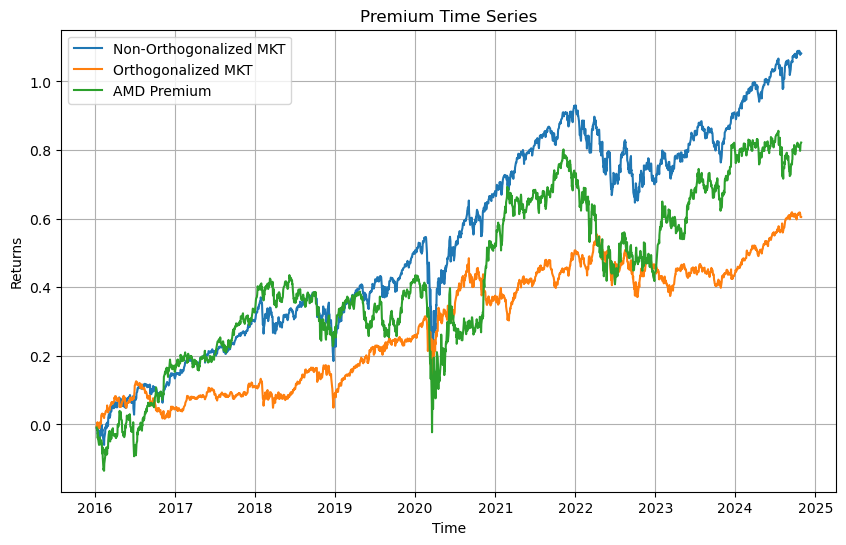

In [61]:
# Obtaining the Real MKT Premium

OMKT = results_mktvsamd.resid
regression_df['OMKT'] = OMKT

# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(regression_df['MKT'].cumsum(), label='Non-Orthogonalized MKT', alpha=1)
plt.plot(regression_df['OMKT'].cumsum(), label='Orthogonalized MKT', alpha=1)
plt.plot(regression_df['AMD'].cumsum(), label='AMD Premium', alpha=1)

# Config
plt.title('Premium Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.grid()

# Show
plt.show()

In [57]:
# Create the X Matrix
x_alt = regression_df[['OMKT', 'SMB', 'HML', 'WML', 'AMD']]

x_alt.corr()

,OMKT,SMB,HML,WML,AMD
OMKT,1.000000,-0.188568,-0.120359,0.113104,0.002825
SMB,-0.188568,1.000000,0.350497,-0.518943,0.586805
HML,-0.120359,0.350497,1.000000,-0.565051,0.196787
WML,0.113104,-0.518943,-0.565051,1.000000,-0.422477
AMD,0.002825,0.586805,0.196787,-0.422477,1.000000


In [59]:
# Calculate Weights
window = len(y)
weights = window * wexp(window, window/2)

#Model specification
model = sm.WLS(
    y, 
    sm.add_constant(x_alt),
    missing='drop',
    weights=weights,
    )   
     
#the results of the model
results = model.fit() 
    
#here we check the summary
print(results.summary())

                             WLS Regression Results                             
Dep. Variable:     stock_excess_returns   R-squared:                       0.433
Model:                              WLS   Adj. R-squared:                  0.431
Method:                   Least Squares   F-statistic:                     334.9
Date:                  Wed, 09 Apr 2025   Prob (F-statistic):          4.66e-267
Time:                          14:55:00   Log-Likelihood:                 5461.2
No. Observations:                  2201   AIC:                        -1.091e+04
Df Residuals:                      2195   BIC:                        -1.088e+04
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000

In [69]:
vif_data_alt = pd.DataFrame()
vif_data_alt['vars'] = x_alt.columns
vif_data_alt['VIF'] = [variance_inflation_factor(x_alt.values, i) for i in range(x_alt.shape[1])]

vif_data_alt

,vars,VIF
0,OMKT,1.063084
1,SMB,1.864550
2,HML,1.509225
3,WML,1.851789
4,AMD,1.618277


### Obtaining the Coefficients for a single stock ###

In [83]:
# Define the Function
def CarhartFactors(
    stock_returns: pd.Series, 
    market_returns: pd.Series = OMKT, 
    small_minus_big_series: pd.Series = SMB,
    high_minus_low_series: pd.Series = HML,
    winners_minus_losers_series: pd.Series = WML,
    aggressive_minus_defensive_series: pd.Series = AMD,
    window: int = 252
) -> pd.DataFrame:
    
    # Asegurar el mismo índice
    common_index = stock_returns.index \
        .intersection(market_returns.index) \
        .intersection(small_minus_big_series.index) \
        .intersection(high_minus_low_series.index) \
        .intersection(winners_minus_losers_series.index) \
        .intersection(aggressive_minus_defensive_series.index)
    
    stock_returns = stock_returns.loc[common_index]
    market_returns = market_returns.loc[common_index]
    small_minus_big_series = small_minus_big_series.loc[common_index]
    high_minus_low_series = high_minus_low_series.loc[common_index]
    winners_minus_losers_series = winners_minus_losers_series.loc[common_index]
    aggressive_minus_defensive_series = aggressive_minus_defensive_series.loc[common_index]
    
    # Crear matriz X
    X_all = pd.concat([
        market_returns,
        small_minus_big_series,
        high_minus_low_series,
        winners_minus_losers_series,
        aggressive_minus_defensive_series
    ], axis=1)
    
    # Inicializar dataframe para betas
    betas = pd.DataFrame(index=stock_returns.index, columns=["mkt_beta", "smb_beta", "hml_beta", "wml_beta", "amd_beta"], dtype=float)
    
    for i in range(window, len(stock_returns)):
        y_window = stock_returns.iloc[i-window:i]
        X_window = X_all.iloc[i-window:i]
        
        if y_window.isna().any() or X_window.isna().any().any():
            continue

        weights = window * wexp(window, window/2)
        X_window = sm.add_constant(X_window)
        model = sm.WLS(y_window, X_window, weights=weights, missing='drop').fit()
        params = model.params

        # Store the betas
        mkt_beta = params.iloc[1]
        smb_beta = params.iloc[2]
        hml_beta = params.iloc[3]
        wml_beta = params.iloc[4]
        amd_beta = params.iloc[5]
        
        betas.iloc[i] = [
            mkt_beta,
            smb_beta,
            hml_beta,
            wml_beta,
            amd_beta
        ]
        
    return betas

In [85]:
# Check if the Fuction Works (Remember the Stock we are using)

parameters = CarhartFactors(
    regression_df['stock_excess_returns'],
).dropna()

parameters

,mkt_beta,smb_beta,hml_beta,wml_beta,amd_beta
Date,,,,,
2017-01-11,1.170634,-0.292511,-1.138590,-0.191545,0.703809
2017-01-12,1.174371,-0.276831,-1.133994,-0.174262,0.711593
2017-01-13,1.176446,-0.293722,-1.139678,-0.179705,0.711294
2017-01-17,1.172954,-0.277769,-1.152752,-0.178606,0.712942
2017-01-18,1.165456,-0.269489,-1.148270,-0.160477,0.717780
...,...,...,...,...,...
2024-10-22,1.249352,-0.067670,-0.141499,0.899234,0.722412
2024-10-23,1.245431,-0.131770,-0.130211,0.889463,0.726332
2024-10-24,1.279884,-0.212405,-0.190561,0.819440,0.747408


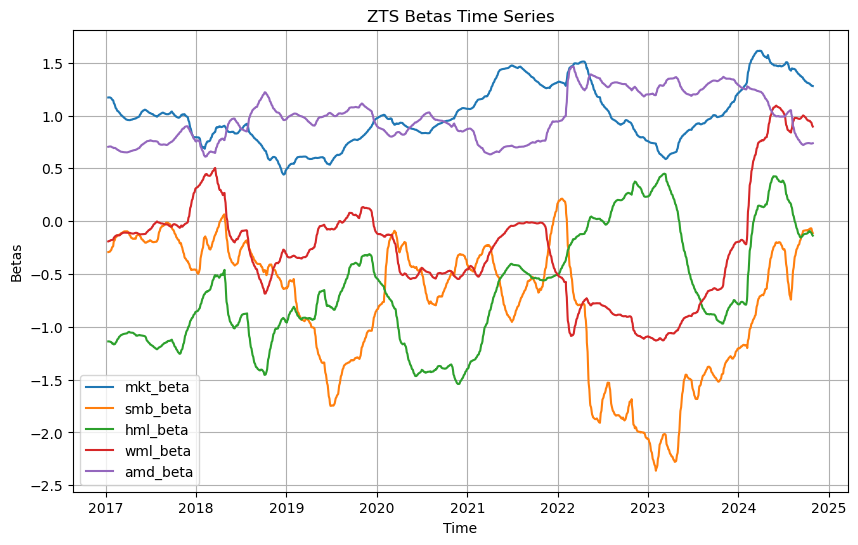

In [86]:
# Create Plot

plt.figure(figsize=(10, 6))
plt.plot(parameters.ewm(span=21, adjust = False).mean(), label=parameters.columns, alpha=1)

# Config
plt.title(f'{ticker} Betas Time Series')
plt.xlabel('Time')
plt.ylabel('Betas')
plt.legend()
plt.grid()

# Show
plt.show()

### Obtaining the Coefficients for all the Stocks ###

In [73]:
# Dictionary to store the DataFrames
folder_path = r"..\stocks"

dataframes = {} 

# List all files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        # Full path to the file
        file_path = os.path.join(folder_path, file)
        
        # Read the Excel file
        df = pd.read_csv(file_path)
        df = df.set_index("Date")
        df.index = pd.to_datetime(df.index)

        df = df['Adjusted_close']

        df = df.rename("adj_close")
        
        # Fill nans
        df = df.interpolate(method='time')

        df = df.loc['2015-01-01':]

        df.dropna(inplace=True)
        
        if len(df) >= 2000:
            # File name without extension
            file_name = os.path.splitext(file)[0]
            
            # Guardar en el diccionario
            dataframes[file_name] = df
            print(f"File loaded: {file_name} ({len(df)} rows)")
        else:
            print(f"File skipped (less than 2000 rows after cleaning): {file}")

print(f"\nTotal files loaded: {len(dataframes)}")
print("Files loaded:", list(dataframes.keys()))

File loaded: A (2472 rows)
File loaded: AAPL (2472 rows)
File loaded: ABBV (2472 rows)
File skipped (less than 2000 rows after cleaning): ABNB.csv
File loaded: ABT (2472 rows)
File loaded: ADBE (2472 rows)
File loaded: ADI (2472 rows)
File loaded: ADM (2472 rows)
File loaded: ADP (2472 rows)
File loaded: ADSK (2472 rows)
File loaded: AEE (2472 rows)
File loaded: AEP (2472 rows)
File loaded: AES (2472 rows)
File loaded: AFL (2472 rows)
File loaded: AIG (2472 rows)
File loaded: AIZ (2472 rows)
File loaded: AJG (2472 rows)
File loaded: AKAM (2472 rows)
File loaded: ALB (2472 rows)
File loaded: ALGN (2472 rows)
File loaded: ALL (2472 rows)
File loaded: AMAT (2472 rows)
File loaded: AMD (2472 rows)
File loaded: AME (2472 rows)
File loaded: AMGN (2472 rows)
File loaded: AMP (2472 rows)
File loaded: AMT (2472 rows)
File loaded: AMZN (2472 rows)
File loaded: ANET (2472 rows)
File loaded: ANSS (2472 rows)
File loaded: AOS (2472 rows)
File loaded: APA (2472 rows)
File loaded: APD (2472 rows)
Fil

In [75]:
# Create a whole new dataframe that contains all the stocks betas

rets_series = []

for stock, df in dataframes.items():
    series = df.pct_change(1).rename(stock)  
    series = series.iloc[1:]
    rets_series.append(series)

# Concat
returns_df = pd.concat(rets_series, axis=1)
returns_df = returns_df.apply(lambda x: x.fillna(x.mean()), axis=0)
returns_df = returns_df.sub(daily_rfr, axis=0)

returns_df.dropna(inplace = True)

returns_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.018794,-0.028228,-0.018875,0.000167,-0.005033,-0.018331,-0.034658,-0.000776,-0.014671,-0.010058,...,-0.013860,-0.000056,-0.017076,-0.011407,-0.027418,-0.062293,-0.020374,0.037247,-0.014133,-0.006059
2015-01-06,-0.015632,0.000040,-0.005004,-0.011410,-0.020199,-0.023438,-0.019767,-0.008405,-0.019829,-0.011695,...,-0.017162,-0.001162,-0.021385,0.005266,-0.005370,-0.005935,-0.012328,-0.008531,-0.007259,-0.009810
2015-01-07,0.013218,0.013968,0.040363,0.008054,0.008170,0.010463,0.014978,0.008730,-0.002141,0.007724,...,0.016164,0.002996,0.029314,0.008581,0.010079,0.007833,0.033084,0.024817,0.025411,0.020589
2015-01-08,0.029919,0.038366,0.010403,0.020498,0.025327,0.017599,-0.014665,0.022884,0.024691,0.003472,...,0.019602,0.010724,0.011975,0.011543,0.016589,0.007490,0.017364,0.010561,0.021303,0.015343
2015-01-09,-0.007391,0.001018,-0.027409,-0.010562,-0.014798,-0.000785,-0.008584,-0.007217,-0.009068,-0.011261,...,-0.011507,-0.001422,0.012445,-0.012339,-0.001464,-0.018917,-0.001821,-0.014478,0.014559,0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.024244,-0.002736,0.011787,-0.007551,-0.009357,-0.004767,-0.007953,0.001364,-0.004600,-0.005441,...,-0.003073,-0.019935,0.010356,0.003827,0.005049,-0.008792,-0.004890,-0.009050,-0.001698,0.000202
2024-10-23,-0.003337,-0.021738,-0.004777,0.007549,-0.016501,0.009813,0.006888,-0.004577,-0.007690,0.016293,...,0.000024,0.006204,-0.017419,0.009935,-0.003678,0.002549,0.004834,0.004105,-0.010626,-0.002859
2024-10-24,-0.017705,-0.000938,0.009306,-0.004131,-0.004568,0.012361,0.007375,-0.002218,-0.001948,-0.002245,...,0.154228,0.008677,0.002138,0.012168,-0.005769,-0.008238,-0.006532,-0.006800,-0.016524,-0.039746


In [77]:
# Create Dicts
betas_mkt_dict = {}
betas_smb_dict = {}
betas_hml_dict = {}
betas_wml_dict = {}
betas_amd_dict = {}

# Loop
for ticker, df in dataframes.items():
    stock_returns = returns_df[ticker]

    # Calculate betas
    parameters = CarhartFactors(stock_returns)

    # Store
    betas_mkt_dict[ticker] = parameters['mkt_beta']
    betas_smb_dict[ticker] = parameters['smb_beta']
    betas_hml_dict[ticker] = parameters['hml_beta']
    betas_wml_dict[ticker] = parameters['wml_beta']
    betas_amd_dict[ticker] = parameters['amd_beta']

    print(f'{ticker} is ready.')

# Create the DataFrames
betas_mkt = pd.concat(betas_mkt_dict, axis=1)
betas_smb = pd.concat(betas_smb_dict, axis=1)
betas_hml = pd.concat(betas_hml_dict, axis=1)
betas_wml = pd.concat(betas_wml_dict, axis=1)
betas_amd = pd.concat(betas_amd_dict, axis=1)

A is ready.
AAPL is ready.
ABBV is ready.
ABT is ready.
ADBE is ready.
ADI is ready.
ADM is ready.
ADP is ready.
ADSK is ready.
AEE is ready.
AEP is ready.
AES is ready.
AFL is ready.
AIG is ready.
AIZ is ready.
AJG is ready.
AKAM is ready.
ALB is ready.
ALGN is ready.
ALL is ready.
AMAT is ready.
AMD is ready.
AME is ready.
AMGN is ready.
AMP is ready.
AMT is ready.
AMZN is ready.
ANET is ready.
ANSS is ready.
AOS is ready.
APA is ready.
APD is ready.
APH is ready.
APO is ready.
ARE is ready.
AWK is ready.
BALL is ready.
BDX is ready.
BK is ready.
BKNG is ready.
BLDR is ready.
BMY is ready.
BR is ready.
BRO is ready.
BSX is ready.
BWA is ready.
BX is ready.
BXP is ready.
C is ready.
CAG is ready.
CAH is ready.
CBRE is ready.
CCI is ready.
CDNS is ready.
CDW is ready.
CE is ready.
CF is ready.
CFG is ready.
CHD is ready.
CHRW is ready.
CHTR is ready.
CI is ready.
CINF is ready.
CL is ready.
CLX is ready.
CMCSA is ready.
CME is ready.
CMG is ready.
CMI is ready.
CMS is ready.
CNC is rea

In [89]:
# See Market Betas
betas_mkt.dropna(inplace = True)

betas_mkt

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-11,1.055133,1.015688,0.768565,1.029593,1.368993,1.012677,1.002204,1.085457,1.408367,1.388722,...,0.948577,1.385514,0.657943,1.349787,0.902348,0.894890,1.129067,0.913625,0.706183,0.825598
2017-01-12,1.058482,1.022506,0.758401,1.025739,1.369599,1.014509,1.003169,1.086516,1.410225,1.387473,...,0.946979,1.387959,0.643831,1.347546,0.897895,0.896066,1.127190,0.917332,0.710447,0.822946
2017-01-13,1.062716,1.020008,0.768319,1.025542,1.365770,1.007396,1.001503,1.086050,1.407165,1.387017,...,0.948205,1.388075,0.646696,1.345571,0.901837,0.897373,1.127650,0.922107,0.709211,0.832797
2017-01-17,1.067292,1.022599,0.762490,1.021909,1.375169,1.008777,0.995852,1.086099,1.419515,1.386163,...,0.950072,1.399199,0.671907,1.348297,0.891906,0.894590,1.122422,0.911894,0.708619,0.834925
2017-01-18,1.075110,1.025453,0.731817,1.029145,1.390984,1.013469,1.003371,1.074986,1.387079,1.379502,...,0.957104,1.418658,0.670164,1.342090,0.921997,0.900970,1.130222,0.929443,0.701365,0.821331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.718329,1.088911,1.099531,0.847061,1.150558,0.911423,0.922374,0.785805,0.965283,1.195277,...,0.506935,0.858563,0.709860,1.070969,0.578235,0.990910,0.786054,1.134383,0.440854,0.988652
2024-10-23,0.729839,1.090575,1.087783,0.849156,1.151456,0.910451,0.924513,0.782934,0.961984,1.195031,...,0.502778,0.861884,0.720162,1.071081,0.581947,1.007329,0.786813,1.133914,0.439266,0.986743
2024-10-24,0.724260,1.095525,1.095555,0.844692,1.126846,0.869312,0.905109,0.772101,0.952910,1.169813,...,0.486262,0.858728,0.728850,1.049029,0.583937,1.004736,0.769669,1.120565,0.447550,0.977289


In [91]:
# See SMB Betas
betas_smb.dropna(inplace = True)

betas_smb

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.552264,-0.539947,-0.395256,0.115486,0.405291,0.628275,0.765101,-0.008502,1.653187,1.226956,...,0.960495,1.341007,0.464659,1.081086,-0.752352,0.831069,0.175523,0.417042,1.311312,-0.652334
2017-01-12,0.575601,-0.533820,-0.455841,0.106110,0.411197,0.627050,0.749184,0.001033,1.657254,1.232859,...,0.930442,1.345772,0.435862,1.095240,-0.741464,0.829023,0.163719,0.425254,1.291993,-0.668902
2017-01-13,0.557731,-0.510299,-0.525551,0.113756,0.441165,0.677658,0.774479,-0.001089,1.675837,1.244309,...,0.921494,1.355278,0.427555,1.108438,-0.764640,0.834603,0.159154,0.394382,1.306765,-0.735392
2017-01-17,0.538966,-0.524063,-0.502367,0.124199,0.404018,0.670689,0.795258,-0.003853,1.632382,1.252338,...,0.906182,1.322155,0.328237,1.100745,-0.730540,0.848010,0.171195,0.424511,1.297643,-0.740628
2017-01-18,0.528513,-0.527789,-0.493246,0.115256,0.404676,0.667828,0.770788,0.013703,1.672692,1.263162,...,0.923281,1.314002,0.299837,1.109177,-0.760161,0.836139,0.183027,0.406942,1.286956,-0.725225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,1.286104,-0.351235,0.314036,0.316217,-2.318917,-0.623707,0.118101,0.117250,0.243726,1.180593,...,0.611413,2.286148,0.678232,0.799818,0.051660,1.103353,0.700925,0.353906,1.114452,0.963755
2024-10-23,1.377364,-0.340002,0.237863,0.353360,-2.250565,-0.616082,0.165549,0.103771,0.239268,1.202356,...,0.584029,2.338372,0.627388,0.781762,0.059349,1.153667,0.700677,0.386126,1.087845,0.924909
2024-10-24,1.417116,-0.370644,0.244713,0.414763,-2.243484,-0.493427,0.210040,0.094754,0.257503,1.246208,...,0.611785,2.383276,0.614759,0.811934,0.028018,1.199294,0.748770,0.444148,1.089423,0.957579


In [93]:
# See HML Betas
betas_hml.dropna(inplace = True)

betas_hml

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-11,-0.549448,-0.787290,-0.570349,-0.505238,-1.153643,-0.645213,0.782986,-0.176438,-1.000770,0.600289,...,-0.656959,0.169415,-0.875063,0.381104,0.803507,0.291386,-0.258377,-0.541289,-0.175428,-0.754813
2017-01-12,-0.542209,-0.786458,-0.588877,-0.507694,-1.151768,-0.645955,0.777464,-0.173425,-0.999738,0.602497,...,-0.666770,0.170576,-0.882199,0.386263,0.807968,0.290486,-0.262005,-0.539197,-0.182687,-0.759903
2017-01-13,-0.540007,-0.776963,-0.606884,-0.502131,-1.142276,-0.632534,0.791787,-0.177068,-0.996615,0.610183,...,-0.669270,0.178950,-0.877563,0.389278,0.804583,0.300392,-0.263947,-0.545628,-0.175382,-0.775500
2017-01-17,-0.529274,-0.761505,-0.618406,-0.497336,-1.124403,-0.625399,0.785694,-0.169289,-0.989147,0.594641,...,-0.642005,0.167686,-0.830604,0.385239,0.801107,0.287894,-0.248103,-0.534440,-0.142246,-0.780941
2017-01-18,-0.533358,-0.763024,-0.592053,-0.501352,-1.139727,-0.628955,0.786438,-0.164358,-0.971214,0.597499,...,-0.654263,0.151735,-0.819737,0.388439,0.781951,0.285644,-0.259389,-0.545516,-0.131852,-0.772943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.450475,-0.630668,0.003941,-0.225221,-0.969821,-0.193183,0.682203,-0.202946,-0.285279,0.426060,...,-0.287878,0.388090,-0.050570,0.263723,1.077945,0.150059,-0.489837,0.069871,0.350101,-0.592012
2024-10-23,-0.457840,-0.631211,0.006944,-0.232021,-0.986679,-0.196639,0.672726,-0.203577,-0.288939,0.419911,...,-0.286701,0.379079,-0.021920,0.268689,1.081352,0.160792,-0.488656,0.060614,0.354843,-0.584485
2024-10-24,-0.431016,-0.652054,0.009324,-0.191653,-0.975839,-0.107733,0.706126,-0.206556,-0.274962,0.454394,...,-0.264732,0.408571,-0.032216,0.293622,1.060828,0.190602,-0.453536,0.101102,0.353725,-0.561191


In [95]:
# See WML Betas

betas_wml.dropna(inplace = True)

betas_wml

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.002487,-0.347115,-0.045844,-0.095769,-0.290404,-0.130129,-0.377381,-0.095000,-0.136316,0.018706,...,0.008289,-0.135590,-0.448778,0.020613,0.024922,0.409391,-0.236185,-0.058977,0.136911,-0.164293
2017-01-12,0.026970,-0.337357,-0.110228,-0.107011,-0.284343,-0.130288,-0.392258,-0.085171,-0.131335,0.023723,...,-0.021717,-0.129604,-0.484584,0.033067,0.032972,0.408068,-0.248670,-0.048944,0.120589,-0.181829
2017-01-13,0.055071,-0.323264,-0.110223,-0.092224,-0.277129,-0.128859,-0.360159,-0.097928,-0.138248,0.043206,...,-0.022496,-0.105213,-0.456632,0.031440,0.043697,0.442951,-0.251814,-0.042579,0.134965,-0.175323
2017-01-17,0.054807,-0.325138,-0.110282,-0.094462,-0.276904,-0.129655,-0.361150,-0.099340,-0.135008,0.045744,...,-0.026811,-0.098988,-0.455848,0.033201,0.040627,0.444209,-0.256680,-0.048450,0.128653,-0.173528
2017-01-18,0.028642,-0.334331,-0.134885,-0.115758,-0.242824,-0.131742,-0.443847,-0.051383,-0.038657,0.075690,...,0.055408,-0.092822,-0.572645,0.054503,-0.017733,0.409528,-0.193953,-0.083659,0.071578,-0.139094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.567379,-0.421920,-0.242603,-0.281300,-0.807789,-0.776665,-0.546303,-0.324759,-0.172639,-0.115916,...,-0.227665,-0.171482,-0.799385,-0.431052,-0.026122,0.267472,-0.436970,-0.565954,-0.280975,-0.558670
2024-10-23,-0.549863,-0.419613,-0.258526,-0.275746,-0.799365,-0.776378,-0.539535,-0.328058,-0.175159,-0.113557,...,-0.233349,-0.163444,-0.798981,-0.433065,-0.022979,0.283254,-0.436538,-0.562526,-0.285007,-0.564308
2024-10-24,-0.518903,-0.443680,-0.255918,-0.229220,-0.786478,-0.673383,-0.500776,-0.331304,-0.158923,-0.073453,...,-0.207792,-0.129455,-0.810975,-0.404003,-0.046629,0.317600,-0.395837,-0.515713,-0.286433,-0.537344


In [97]:
# See AMD Betas
betas_amd.dropna(inplace = True)

betas_amd

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-11,0.930114,0.564624,0.831937,0.745073,0.721783,0.790780,0.316929,0.452616,1.160137,-0.497748,...,0.453968,0.499555,0.922228,-0.525952,0.513715,0.680040,0.526907,0.619760,1.134754,0.770296
2017-01-12,0.940035,0.571698,0.805076,0.739200,0.724113,0.791771,0.312608,0.456436,1.162825,-0.496816,...,0.443236,0.502906,0.902476,-0.523151,0.513815,0.680277,0.521752,0.625155,1.131838,0.763046
2017-01-13,0.955526,0.575156,0.814331,0.745089,0.723503,0.785721,0.324237,0.450762,1.157132,-0.489240,...,0.444061,0.513032,0.916628,-0.525662,0.521899,0.695822,0.520890,0.632224,1.136589,0.774909
2017-01-17,0.955331,0.572167,0.813920,0.741158,0.724381,0.784467,0.322281,0.448408,1.163201,-0.485048,...,0.436957,0.524020,0.919286,-0.522576,0.516242,0.697774,0.512488,0.621875,1.126020,0.778019
2017-01-18,0.945973,0.568963,0.775052,0.734231,0.757128,0.786937,0.279110,0.468103,1.194777,-0.472530,...,0.491350,0.543069,0.848538,-0.514833,0.505376,0.682221,0.555911,0.614841,1.086385,0.787721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,0.534124,0.566861,-0.076876,-0.073004,0.737395,1.439887,0.327879,0.130581,0.830559,-0.227189,...,0.404878,0.306445,0.751421,-0.166643,0.189139,0.559383,0.119513,0.273003,1.044961,0.260443
2024-10-23,0.530422,0.566484,-0.074466,-0.075331,0.732173,1.438964,0.324735,0.130757,0.829872,-0.229020,...,0.405766,0.303291,0.758784,-0.165153,0.189697,0.560537,0.119773,0.270259,1.046601,0.262967
2024-10-24,0.524116,0.571578,-0.072425,-0.083586,0.722595,1.410940,0.312965,0.127856,0.824647,-0.242802,...,0.396844,0.297294,0.763263,-0.176318,0.193806,0.554663,0.108422,0.259190,1.049396,0.256041


In [99]:
# Save

betas_mkt.to_csv(r'..\additional_data\carhart_mkt_betas.csv')
betas_smb.to_csv(r'..\additional_data\carhart_smb_betas.csv')
betas_hml.to_csv(r'..\additional_data\carhart_hml_betas.csv')
betas_wml.to_csv(r'..\additional_data\carhart_wml_betas.csv')
betas_amd.to_csv(r'..\additional_data\carhart_amd_betas.csv')